# Spam Filter<a href="#Machine-Learning-Assignment-2---A-Spam-Classifier" class="anchor-link">¶</a>

**Group 5:** Gabriela Garcia, Achyuthuni Harsha, Rada Georgeva, Ahmed
Khedr, Ankit Mahajan, Persa Marathefti

In this assignment we will be leveraging SMS data from the UCI Machine
Learning Repository:
<https://archive.ics.uci.edu/ml/machine-learning-databases/00228/>

The main goal of this assignment is to build a Naive Baye's Spam Filter.

In [11]:
#Import for data analysis

import pandas as pd
import numpy as np

#Import for vizualization

import seaborn as sns;
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#Import for Classifier
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
from sklearn import metrics
from dmba import classificationSummary, gainsChart

#Import for Text Preprocessing
import string
import nltk
from nltk.stem import SnowballStemmer #used for applying stemming 
from nltk.tokenize import word_tokenize  #helps to tokenize the words and converts sentences to list of words
from nltk.corpus import stopwords #gives the list of stopwords from nltk package
import re    

#downlaods for nltk
nltk.download('punkt')
nltk.download('stopwords')

pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/radageorgieva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/radageorgieva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1 - Load the Data<a href="#Step-1---Load-the-Data" class="anchor-link">¶</a>

We will begin by loading the data by leveraging the read_csv function.
In addition, we will assign column names for readability.

In [7]:
df_sms_spam = pd.read_csv('SMSSpamCollection.csv',sep='\t', header= None,names=["Class", "SMS"])
df_sms_spam.head()

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis of the Data set<a href="#Exploratory-Data-Analysis-of-the-Data-set" class="anchor-link">¶</a>

It is important to get an overall understanding of the dataset we will
be working with.

In [8]:
df_sms_spam.shape

(5572, 2)

The below countplot (similar to a histogram but for categorical outputs)
shows 5572 observations in the total data set, 4825 are "ham" and 747
are "spam" messages which account for 86.6% and 13.4% split. Hence, the
dataset does have class imbalance. In this case as we are dealing with
probabilistic models we won't implement techniques to balance our
dataset (such as oversampling), however, it is still important to know
the proportions of classes we are initially working with. The
implication is that when choosing the right model we would need to use
additional metrics such as precision/specificity or recall/senstivity
along with accuracy score to choose the best model.

ham     4825
spam     747
Name: Class, dtype: int64
ham     0.865937
spam    0.134063
Name: Class, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


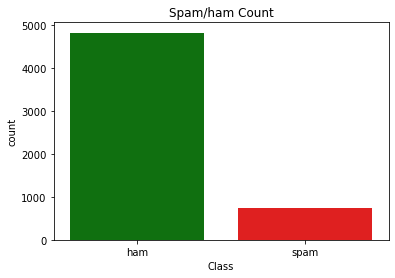

In [12]:
print(df_sms_spam['Class'].value_counts())
print(df_sms_spam['Class'].value_counts(normalize=True))
print(sns.countplot(x="Class", data=df_sms_spam, palette=["green","red"]))
plt.title('Spam/ham Count')
plt.show()

#### Visualization of the most common words in the dataset for each class of SMS<a href="#Visualization-of-the-most-common-words-in-the-dataset-for-each-class-of-SMS" class="anchor-link">¶</a>

Below word clouds of spam and ham messages are visualized. They show that the words which are the most common in each class are different. Hence, we should be able to predict "ham" and "spam" in new sms messages which uses the frequency of such words by building a classifier.

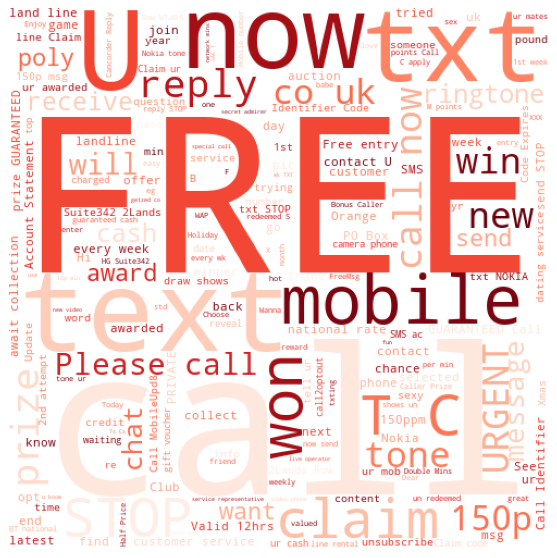

In [13]:
# Wordcloud SPAM
spam_w = ' '.join(list(df_sms_spam[df_sms_spam['Class'] == 'spam']['SMS']))
spam_wc = WordCloud(width = 500, height = 500, background_color = "white", colormap = 'Reds').generate(spam_w)
plt.figure(figsize = (10, 10))
plt.imshow(spam_wc)
plt.axis('off')

plt.show()

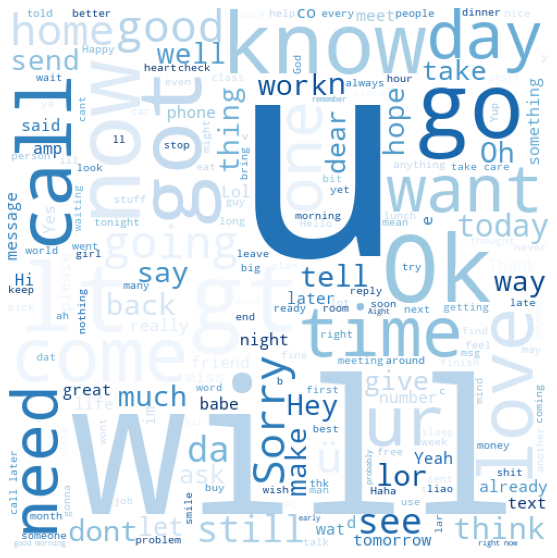

In [14]:
# Wordcloud HAM

ham_w = ' '.join(list(df_sms_spam[df_sms_spam['Class'] == 'ham']['SMS']))
ham_wc = WordCloud(width = 500, height = 500, background_color = 'white', colormap = 'Blues').generate(ham_w)
plt.figure(figsize = (10, 10))
plt.imshow(ham_wc)
plt.axis('off')

plt.show()

### Step 2 - Pre processing the Data<a href="#Step-2---Pre-processing-the-Data" class="anchor-link">¶</a>

So our approach is to pre-process the data in the following order :

1.  **Change the characters to lowercase**
2.  **Remove stop words** - This is used before removing the numbers and
    punctuations because stop word list in "nltk" also has punctuated
    words.
3.  **Remove numbers**
4.  **Remove punctuations** - This is done before stemming so that if we
    have a website it is seperated to words before applying stemming.
    Example www.google.com would be three word i.e. (www, google, com)
5.  **Apply stemming** - This makes the training data more dense(less
    unique words and more counts) as it buckets the words with the same
    corpus into same word. It also sometimes catches misspelt words.We
    expect this to improve the performance of the machine learning
    model.

In [15]:
# create a set of stop words to be used in comparison later 
#stop_words = set(stopwords.words('english'))

stop_words = nltk.corpus.stopwords.words('english')

#create a stemmer to be used later to combine similar words 
ss = SnowballStemmer(language='english')

In [16]:
# Pre processing the data as per the approach above

#change to lower case
df_sms_spam['SMS'] = df_sms_spam['SMS'].str.lower()

# remove the stop words
df_sms_spam['SMS'] = df_sms_spam['SMS'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

# removing the numbers 
df_sms_spam['SMS'] = df_sms_spam['SMS'].str.replace('\d+', ' ')

#remove punctuations
for p in list(string.punctuation):
    df_sms_spam['SMS'] = df_sms_spam['SMS'].str.replace(p, ' ')
    
#apply stemming
df_sms_spam['SMS'] = df_sms_spam['SMS'].apply(lambda x: ' '.join([ss.stem(word) for word in x.split() if word not in (stop_words)]))

<ipython-input-16-215027f13fd2>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sms_spam['SMS'] = df_sms_spam['SMS'].str.replace('\d+', ' ')
<ipython-input-16-215027f13fd2>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_sms_spam['SMS'] = df_sms_spam['SMS'].str.replace(p, ' ')


Decomposing the SMS into a list of seperate words. This would be used to
prepare a frequency matrix later on.

In [17]:
df_sms_spam['SMS_tokenized'] = df_sms_spam['SMS'].apply(word_tokenize)
df_sms_spam.head()

,Class,SMS,SMS_tokenized
0,ham,go jurong point crazi avail bugi n great world...,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]"
2,spam,free entri wkli comp win fa cup final tkts st ...,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,u dun say earli hor u c alreadi say,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,nah think goe usf live around though,"[nah, think, goe, usf, live, around, though]"


There are a total of 6314 words derived. However we wouldnt be using all the words to train the model, only the ones which would be part of the training data set. In the next step we will split out data into training and test dataset.

In [18]:
# Count of all words 
vec = CountVectorizer()
matrix = vec.fit_transform(df_sms_spam['SMS'])
counts = pd.DataFrame(matrix.toarray(),
             
                    index=df_sms_spam['SMS'],
                  columns=vec.get_feature_names())

print("number of unique words: " +str(counts.shape[1]))

number of unique words: 6314


### Step 3 - Shuffle the messages and split them into a training set (two thirds) and a test set (one third)<a href="#Step-3---Shuffle-the-messages-and-split-them-into-a-training-set-(two-thirds)-and-a-test-set-(one-third)" class="anchor-link">¶</a>

Splitting the data into training and test set utilizing standard sklearn
library function.

-   As asked in the question, training set and test set are split into
    2/3 and 1/3 ratio respectively.
-   We are using stratified sampling to ensure that the ratio of spam
    and ham is maintained in training and test data set.
-   Sklearn function also does the shuffling (asked in the question) by
    default.
-   Random state is defined to ensure shuffling is done in the same way
    each time and we get reproducible results.

In [20]:
x_train,x_test, y_train, y_test = train_test_split(
    df_sms_spam['SMS_tokenized'], df_sms_spam['Class'], test_size= 1/3, 
    random_state=35,stratify= df_sms_spam['Class'])

### Step 4- Use the Naïve Bayes package of scikit-learn to train a Naïve Bayes classifier on the training set and then evaluate the performance of that classifier on both the training and the test set<a href="#Step-4---Use-the-Naïve-Bayes-package-of-scikit-learn-to-train-a-Naïve-Bayes-classifier-on-the-training-set-and-then-evaluate-the-performance-of-that-classifier-on-both-the-training-and-the-test-set" class="anchor-link">¶</a>

One of the simple methods of encoding data is by word count

1.  Take each snippet of text
2.  Count the occurrences of each word within it
3.  put the results in a table

We call "vectorization" the general process of turning a collection of
text documents into numerical feature vectors.

According to Jake Vanderplas (2016) There is one issue with this
approach.The raw word counts lead to features that put too much weight
on words that appear very frequently, and this can be suboptimal in some
classification algorithms. One approach to fix this is known as term
frequency–inverse document frequency (TF–IDF), which weights the word
counts by a measure of how often they appear in the documents.

In sklearn we can do this using TFID Vectorizer which would create the
required frequency matrix

In [21]:
# initiate the TFID vector from sklearn
tfid_vector = TfidfVectorizer(input = "english",stop_words='english')

In [22]:
# fit and transform TFID vector on training data
x_train_tfid_Matrix = tfid_vector.fit_transform(x_train.apply(str))

# transform the test data using the tfid vector but using the parameters of training data
x_test_tfid_Matrix =  tfid_vector.transform(x_test.apply(str))

In [23]:
# visualize the frequency matrix also termed as bag of words representation for training set
pd.DataFrame(x_train_tfid_Matrix.toarray(), columns=tfid_vector.get_feature_names())

,aah,aaniy,aathi,abbey,abdomen,abeg,abel,abi,abil,abiola,...,zed,zero,zf,zhong,zindgi,zoe,zs,zyada,èn,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#ensuring the split was done 2/3 to 1/3 for training and test set
print("Training set has", x_train_tfid_Matrix.shape[0], "rows, which is", round(100*(x_train_tfid_Matrix.shape[0]/df_sms_spam.shape[0]),2), "% of total data size")
print("Test set has", x_test_tfid_Matrix.shape[0], "rows, which is", round(100*(x_test_tfid_Matrix.shape[0]/df_sms_spam.shape[0]),2), "% of total data size")

#ensuring the training set of words is used in the testing set so number of columns is the same 
print("Training set has", x_train_tfid_Matrix.shape[1], "columns")
print("Test set has", x_test_tfid_Matrix.shape[1], "columns")

Training set has 3714 rows, which is 66.65 % of total data size
Test set has 1858 rows, which is 33.35 % of total data size
Training set has 5037 columns
Test set has 5037 columns


#### Modelling<a href="#Modelling" class="anchor-link">¶</a>

Based on some information from Jake Vanderplas (2016) The top candidates
for Naive bayes models could be of the following types, based on feature
distribution of our data set:

-   **Gaussian**: It assumes that features follow a normal distribution.
    This is not the case in our data hence we do not use this.

-   **Multinomial**: It is used for discrete counts where the features
    are assumed to be generated from a simple multinomial distribution.
    In our data the value counts ranged from 0 to 12 which were
    converted into the frequency distribution. This is one of the
    candidates.

-   **Bernoulli**: The binomial model is useful if your feature vectors
    are binary (i.e. zeros and ones).0's and 1's are the most common in
    our dataset. If we consider any count great than or equal to 1 as
    presence of the feature, it will fit the benoulli distributon.
    Hence, this is also another viable candiate.

Hence, we would now use both multinomial and bernoulli classifiers, and
proceed to observe the results.

#### First, evaluating Multinomial on both training and test data<a href="#First,-evaluating-Multinomial-on-both-training-and-test-data" class="anchor-link">¶</a>



In [27]:
# initiate the multinomial naive bayes classifier 
mnb = MultinomialNB()
# set grid parameters for hyper parameter tuning
grid_parameters = {'alpha': np.linspace(0.01,1,100)}
# initiate grid search
mnb_cv = GridSearchCV(mnb,grid_parameters, cv=5)
# initiate grid search
mnb_cv = GridSearchCV(mnb,grid_parameters, cv=5)
#fit the classifier on training data
mnb_cv.fit(x_train_tfid_Matrix, y_train)

# Print the tuned parameter and score
print("Tuned Naive Bayes Parameters: {}".format(mnb_cv.best_params_))
print("Best accuracy score is {}".format(mnb_cv.best_score_))

Tuned Naive Bayes Parameters: {'alpha': 0.33}
Best accuracy score is 0.9798050447482887


[[3214    2]
 [  26  472]]
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      3216
        spam       1.00      0.95      0.97       498

    accuracy                           0.99      3714
   macro avg       0.99      0.97      0.98      3714
weighted avg       0.99      0.99      0.99      3714



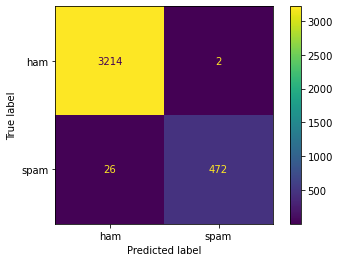

In [28]:
y_pred_training = mnb_cv.predict(x_train_tfid_Matrix)
print(confusion_matrix(y_train,y_pred_training))
print(classification_report(y_train,y_pred_training))
plot_confusion_matrix(mnb_cv, x_train_tfid_Matrix, y_train, values_format='.5g')

**Comments on multinomial classifier performance on training data**

First, we assumed the class of interest is the spam class

1.  we can see that the classifier has very good accuracy 0.99 which
    means the naïve bayes class conditional independence assumption
    didn't affect much our classifier relatability, and the classifier
    has a very low misclassification rate
2.  The sensitivity (accuracy of identifying spam emails) is 0.95
3.  The specificity (accuracy of identifying ham emails) is almost 1.00,
    which means the classifier almost identified correctly all the ham
    emails in the training dataset

##### Multinomial Classifier performance on test dataset<a href="#Multinomial-Classifier-performance-on-test-dataset" class="anchor-link">¶</a>



In [29]:
y_pred = mnb_cv.predict(x_test_tfid_Matrix)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1609    0]
 [  38  211]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1609
        spam       1.00      0.85      0.92       249

    accuracy                           0.98      1858
   macro avg       0.99      0.92      0.95      1858
weighted avg       0.98      0.98      0.98      1858



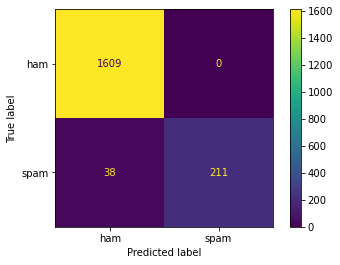

In [30]:
plot_confusion_matrix(mnb_cv, x_test_tfid_Matrix, y_test, values_format='.5g')

**Comments on multinomial classifier performance on test data**

1.  we can see that the classifier has very good accuracy 0.98 which
    seems to be very high
2.  The sensitivity (accuracy of identifying spam emails) is 0.85, which
    is lower than that of the training data, but the 0.85 is more
    representative for the future performance of the classifier
3.  The specificity (accuracy of identifying ham emails) is exactly
    1.00, which means the classifier is estimated to correctly identify
    almost all the ham emails in new unseen data

##### Plotting Learning curves:<a href="#Plotting-Learning-curves:" class="anchor-link">¶</a>

Learning curves show experience on the x-axis and learning on the
y-axis.The learning in this case is represented by accuracy. We have the
following two curves

-   Train Learning Curve: calculated on the training dataset and shows
    how well the model is learning.
-   Cross-Validation Learning Curve: it is calculated on a hold-out
    validation and shows generalization of the model

Based on the development of the above two, we can understand whether the
models underfits, overfits or fits just well.

-   Underfit: when flat line or noisy values, the gap between the
    performance of training set and validation set does not decrease
    with experince
-   Overfit: Training performances continues to increase with experience
    or validation performance increases to a point where it starts to
    decrease again even though training size increases
-   Fits well: Training performance reaches a point of stability and
    validation performance increases to a point of stability where the
    gapbetween the two pperformances decreases before the point of
    stability is reached.

In [31]:
# function plots the learning curves for the given models
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, 
                                                            X=X, 
                                                            y=y,
                                                            random_state=0, 
                                                            cv=5, 
                                                            train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.style.use('seaborn')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    plt.legend()
    print(f"Last accuracy:{test_scores_mean[-1]}")
    return plt.show()

Last accuracy:0.9779197033952107


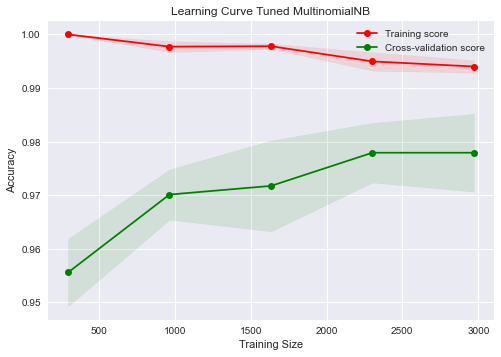

In [32]:
plot_learning_curve(mnb_cv, x_train_tfid_Matrix, y_train, title="Learning Curve Tuned MultinomialNB")

Based on the above theoretical background, we can conclude that the model generalizes well. If we continue training a good fit model, it will likely overfit, so, we can consider the above one optimized.

#### Secondly, evaluating Bernoulli classifier on both training and test data<a href="#Secondly,-evaluating-Bernoulli-classifier-on-both-training-and-test-data" class="anchor-link">¶</a>

In [33]:
#initiate the bernoulli classifier
bnb = BernoulliNB()
# initiate grid search
bnb_cv = GridSearchCV(bnb,grid_parameters, cv=5)

#fit the classifier on training data
bnb_cv.fit(x_train_tfid_Matrix, y_train)

# Print the tuned parameter and score
print("Tuned Benoulli Naive Bayes Parameters: {}".format(bnb_cv.best_params_))
print("Best score is {}".format(bnb_cv.best_score_))

Tuned Benoulli Naive Bayes Parameters: {'alpha': 0.02}
Best score is 0.9824990114382939


##### Bernoulli classifier performance on training dataset<a href="#Bernoulli-classifier-performance-on-training-dataset" class="anchor-link">¶</a>



In [38]:
y_pred_training = bnb_cv.predict(x_train_tfid_Matrix)
print(confusion_matrix(y_train,y_pred_training))
print(classification_report(y_train,y_pred_training))

[[3213    3]
 [   6  492]]
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3216
        spam       0.99      0.99      0.99       498

    accuracy                           1.00      3714
   macro avg       1.00      0.99      0.99      3714
weighted avg       1.00      1.00      1.00      3714



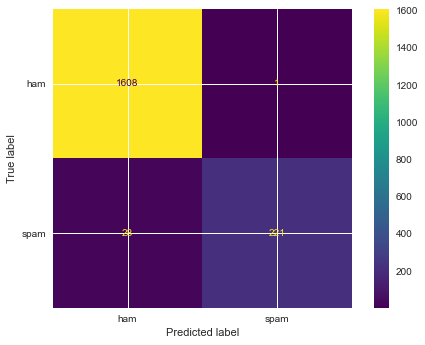

In [37]:
plot_confusion_matrix(bnb_cv, x_test_tfid_Matrix, y_test, values_format='.5g')

**Comments on Bernoulli classifier performance on training data**

we also assumed the class of interest is the spam class

1.  we can see that the classifier has very good accuracy \~1.00 which
    means the naïve bayes class conditional independence assumption
    didn't affect much our classifier relatability, and the classifier
    has a very low misclassification rate, it almost classifies all
    email correctly
2.  The sensitivity (accuracy of identifying spam emails) is 0.99 (this
    is higher than 0.95 obtained from Multinomial)
3.  The specificity (accuracy of identifying ham emails) is almost 1.00,
    which means the classifier almost identified correctly all the ham
    emails in the training dataset - this result is similar to the
    Multinomial version

##### Bernoulli classifier performance on test dataset<a href="#Bernoulli-classifier-performance-on-test-dataset" class="anchor-link">¶</a>

[[1608    1]
 [  28  221]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1609
        spam       1.00      0.89      0.94       249

    accuracy                           0.98      1858
   macro avg       0.99      0.94      0.96      1858
weighted avg       0.98      0.98      0.98      1858



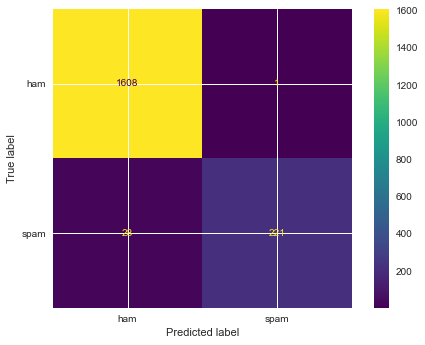

In [35]:
y_pred = bnb_cv.predict(x_test_tfid_Matrix)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
plot_confusion_matrix(bnb_cv, x_test_tfid_Matrix, y_test, values_format='.5g')

Based on the above theoretical background, we can conclude that looks
good in terms of validation learning, as it increases quite
significantly as training size increases. However, the training learning
curve fluctuates more compared to the one of MultinomialNB and the gap
between the two learnings does not decrease as much. Hence, there is
more variance in this model. Based on this, and the fact that the last
accuracy. The last accuracy of the BernoulliNB (of the validation set)
is better. This ilustrates the bias-variance trade-off we have to face.

#### Conclusions about the models<a href="#Conclusions-about-the-models" class="anchor-link">¶</a>

-   Both the Bernoulli and the Multinomial models perform very well in
    terms of weighted accuracy. However, as we said in the beginning, we
    have an imbalanced dataset skewed towards "ham" text messages.
    Hence, it is important to look at sensitivity and specificity scores
    for the two classes. What we can conclude, is that while the two
    have similar weighted accuracy, MultinomialNB is better in
    predicting "ham" text messages, while Bernoulli is better at
    predicting "spam" messages. If the goal of the task is to filter out
    spam, we would probably be better off using the Bernoulli Naive
    Bayes. Overall, both models show very good results, generalization
    is not an issue and none of the scores showing performance of
    separate classes raise concerns unless we are looking for a
    classifier that has zero tolerance in spam.

-   A random classifer that labels emails as spam, ham emails randomly
    based on the historical fraction of ham/spam emails already recieved
    (86.6% ham and 13.4% spam) will overall accuracy = 1-
    ((0.134*0.866)+(0.866*0.134)) = 0.77 (based on Gini index idea), and
    hence it's evident that both of our classifiers performs better than
    this random classifier.

Based on all the above, one can say this is a good classifier.

##### Further ideas to improve the classifier:<a href="#Further-ideas-to-improve-the-classifier:" class="anchor-link">¶</a>

In the present problem, we could ignore the words that are present only
once or twice in the whole dataset, as they are likely nouns or words
which do not have significant impact on whether the message is spam or
ham. This can be helpful as we can filter out new words (which have less
frequency) while predicting in a new unseen dataset. To add to the
model, we could also add if a monetary value is present in the SMS: we
could add two columns, presence of currency symbol (bool indicating
presence of \$, pound, etc) and the presence of a number (bool
indicating the presence of a number). intuitively messages which have a
dollar symbol or currency are more probably spam, and these could be
important features in the model. In text type of data, it is hard to
assume independence between the words. For example, not all words can be
the next word in this *\_\_*. The blank cannot take any word that we
want if it has to make sense, and the word is therefore correlated to
other words present in the sentence. Additionally, in SMS and text data,
the order is important. Consider the below 2 SMS's: 1. Are you free for
30 mins time? Need to talk now! 2. Free talk time of 30 mins if you act
now! In both the statements, the words are similar. But the first
statement looks to be from a friend who needs to talk while the second
is a spam advertisement. In traditional language, the order of words is
important to determine the meaning, not just the presence and frequency
of words. Despite this, we have a good accuracy using Naive Bayes
classifier.

**References**

VanderPlas, J. (2016). Python Data Science Handbook: Essential Tools for
Working with Data. Sebastopol, CA: O’Reilly Media, Available from:
<https://ebookcentral-proquest-com>. \[Accessed 6th June 2021\].